In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns

# Assignment 1 - House Price Prediction
### Laurens ten Cate - MBD'18 - Machine Learning II

###### If you decide to use some of my code/ideas for your own kaggle submissions/kernel submissions I would really appreciate you giving me some credit! Thanks!

Personally I was inspired with model stacking by Serigne's great notebook.
(https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

**kaggle score notes**
- Kaggle username: Laurenstc
- Kaggle final best score: RMSLE = 0.11383
- Kaggle final best score rank: 81

**local score notes**

Locally I managed when to obtain consistent RMSE's of below 0.10. However, this notebook does not include my best local RMSE score as this was due to a ton of overfitting.

**final delivery notes**

The experimental dataset we are going to use is the House Prices Dataset. It includes 79 explanatory variables of residential homes. For more details on the dataset and the competition see https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

The workbook is structured as followed:

1. Data Cleaning and Pre-processing
    - Outliers
    - Statistical transformations
2. Feature Engineering
    - Concatenation
    - NA's
    - Incorrect values
    - Factorization
    - Further Statistical transformation
    - Column removal
    - Creating features
    - Dummies
    - In-depth outlier detection
    - Overfit prevention
    - Baseline model
3. Feature Selection
    - Filter methods
        - baseline coefficients
    - Embedded methods
        - L2: Ridge Regression
        - L1: Lasso regression
            - In-depth coefficient analysis
        - Elasticnet
        - XGBoost
        - SVR
        - LightGBM
3. Ensemble methods
    - Stacked generalizations
    - Averaging
        - standard
        - weighted
4. Prediction


This notebook represents the data manipulation used for my final score on Kaggle (RMSLE = 0.11383). However, in the process of achieving this score a lot of different feature engineering tactics were employed. For the sake of brevity I left these out of the notebook though below is a quick overview of other things I tried that did not help my score. 

One thing that was used but was not included is GridsearchCV. Gridsearching helped me find ranges of Alphas and L1_ratios that I could reuse later. However, it became unfeasible to continuously gridserach for optimal parameters with each iteration of feature engineering. Thats why I decided to omit the code from the final delivery.

**feature engineering tries**
- Recoding categoricals to keep ordering information (if data was really ordinal)
- Binning date variables (yearbuilt etc)
- simplify and recode neighborhood variable based on a groupby with SalePrice
- create simplified quality variables (1-5 scale instead of 1-10)
- create 2nd and 3rd order polynomials of top10 strongest correlating variables with SalePrice
- create 2nd and 3rd order polynomials of all variables
- create interaction variables by looking at individual interaction plots
- use sklearns PolynomialPreprocessing for complete set of interaction and polynomial terms

**feature selection tries**
- F-score selection 
- Mutual information regression selection
- Backwards stepwise selection (RFECV)
- Forwards stepwise selection (LARS)

Besides feature selection and engineering a lot of time was spent on optimizing my ensemble of models. I believe some more gains can be made here specifically regarding my stacked generalization model.

In the end I believe the biggest gains in my score were achieved with a few things. OLS outlier removal, nuanced NA filling and averaging with a stacked generalization model.


In [2]:
#Data reading

train = pd.read_csv("c:/Users/Laurens/Documents/IE-BIGDATA/Term 2/Machine Learning II/lab1/train.csv")
test = pd.read_csv("c:/Users/Laurens/Documents/IE-BIGDATA/Term 2/Machine Learning II/lab1/test.csv")

In [3]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# 1. Data Cleaning and Pre-processing
## Outliers
According to the documentation of the dataset (http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) there are outliers present that are recommended to be removed. Let's plot SalePrice vs GR LIV AREA to view these. 

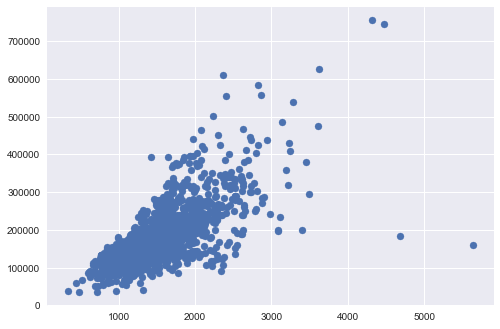

In [4]:
plt.scatter(train.GrLivArea, train.SalePrice)

These outliers are extremely clear. The documentation recommends removing all houses above 4000 sq ft living area. Trial and error showed that this led to a little bit underfitting. Better performance was above 4500 sq.

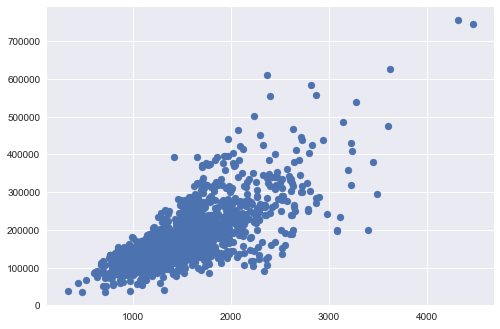

In [5]:
train = train[train.GrLivArea < 4500]
plt.scatter(train.GrLivArea, train.SalePrice)

In [6]:
print(len(np.unique(train['Id'])) == len(train))
len(np.unique(test['Id'])) == len(test)

True


True

In [7]:
len(train)

1458

So we can safely drop the Id columns.

In [8]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [9]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1458, 80)
Test set size: (1459, 79)


## Statistical transformation
Let's have a look at how the target variable is distributed.

In [10]:
df = pd.concat([train.SalePrice, np.log(train.SalePrice + 1).rename('LogSalePrice')], axis=1, names=['SalePrice', 'LogSalePrice'])
df.head()

,SalePrice,LogSalePrice
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


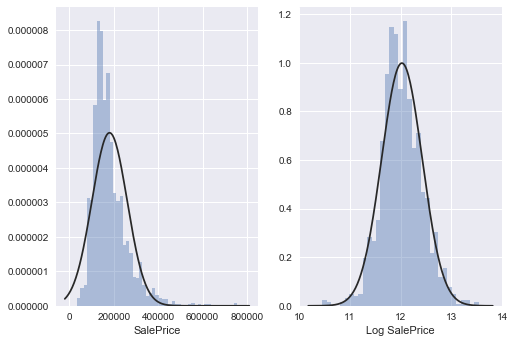

In [11]:
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

There seems to be clear evidence of right-skewedness in the target variable. We can correct this with a simple log transformation.

In [12]:
train.SalePrice = np.log1p(train.SalePrice)

# 2. Feature Engineering
## Concatenation
To keep consistency between test and train features we concatenate the two sets while remembering the index so we can split it later again.

In [13]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [14]:
print(train_features.shape)
print(test_features.shape)

(1458, 79)
(1459, 79)


In [15]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2917, 79)

## NA's
Let's figure out what NA's excist, sort them by categories and impute them in the best possible way.

In [16]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

Most of these can be filled with 'None'. Some exceptions though:

- Functional: The documentation says that we should assume "Typ", so lets impute that.
- Electrical: The documentation doesn't give any information but obviously every house has this so let's impute the most common value: "SBrkr".
- KitchenQual: Similar to Electrical, most common value: "TA".
- Exterior 1 and Exterior 2: Let's use the most common one here. 
- SaleType: Similar to electrical, let's use most common value.


In [17]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

Let's check some points individually to figure out the best imputation strategy

In [18]:
pd.set_option('max_columns', None)
features[features['PoolArea'] > 0 & features['PoolQC'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
809,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1169,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1181,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1384,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,TA,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1421,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1972,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,Ex,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2418,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2571,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8

There are three NaN's foor PoolQC that have a PoolArea. Let's impute them based on overall quality of the house.

In [19]:
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'

In [20]:
pd.set_option('max_columns', None)
features[(features['GarageType'] == 'Detchd') & features['GarageYrBlt'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


So there are houses with garages that are detached but that have NaN's for all other Garage variables. Let's impute these manually too.

In [21]:
features.loc[2124, 'GarageYrBlt'] = features['GarageYrBlt'].median()
features.loc[2574, 'GarageYrBlt'] = features['GarageYrBlt'].median()

features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]

features.loc[2574, 'GarageCars'] = features['GarageCars'].median()

features.loc[2124, 'GarageArea'] = features['GarageArea'].median()
features.loc[2574, 'GarageArea'] = features['GarageArea'].median()

features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]

features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]

Let's look at the basements:
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtFinSF1
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF

In [22]:
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF']

tempdf = features[basement_columns]
tempdfnulls = tempdf[tempdf.isnull().any(axis=1)]

In [23]:
#now select just the rows that have less then 5 NA's, 
# meaning there is incongruency in the row.
tempdfnulls[(tempdfnulls.isnull()).sum(axis=1) < 5]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0
947,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0
1485,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
2038,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
2183,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
2215,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
2216,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
2346,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0
2522,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0


Let's impute all incongruencies with the most likely value.

In [24]:
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

Zoning is also interesting

In [25]:
subclass_group = features.groupby('MSSubClass')
Zoning_modes = subclass_group['MSZoning'].apply(lambda x : x.mode()[0])
Zoning_modes

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [26]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

For the rest we will just use a loop to impute 'None' value. 

In [27]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
LotFrontage   486  float64
GarageYrBlt   157  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
There are 9 columns with missing values


Now let's think about imputing the missing values in the numerical features. Most of the time I will impute 0, but sometimes something else is needed.

- LotFrontage: This is linear feet of street connected to property. Let's impute with the median per neighborhood since I assume this is extremely linked to what kind of area you live in.

In [28]:
neighborhood_group = features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
lot_medians

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

As expected the lotfrontage averages differ a lot per neighborhood so let's impute with the median per neighborhood.

In [29]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Let's also take a closer look at GarageYrBlt

In [30]:
pd.set_option('max_columns', None)
features[(features['GarageYrBlt'].isnull()) & features['GarageArea'] > 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


GarageYrBlt does not have any incongruencies. Let's also examine MasVnrArea.

In [31]:
pd.set_option('max_columns', None)
features[(features['MasVnrArea'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
234,60,RL,64.0,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625.0,Unf,0.0,235.0,860.0,GasA,Ex,Y,SBrkr,860,1100,0,1960,1.0,0.0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2.0,440.0,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal
528,20,RL,70.0,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219.0,Unf,0.0,816.0,2035.0,GasA,TA,Y,SBrkr,2515,0,0,2515,1.0,0.0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2.0,484.0,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca
649,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,813.0,813.0,GasA,Ex,Y,SBrkr,822,843,0,1665,0.0,0.0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2.0,562.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
935,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833.0,Unf,0.0,343.0,1176.0,GasA,Ex,Y,SBrkr,1200,0,0,1200,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2.0,555.0,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal
972,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1428.0,1428.0,GasA,Ex,Y,SBrkr,1428,0,0,1428,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2.0,480.0,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial
976,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106.0,Unf,0.0,135.0,1241.0,GasA,Ex,Y,SBrkr,1241,0,0,1241,1.0,0.0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2.0,569.0,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial
1242,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial
1277,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804.0,Unf,0.0,324.0,1128.0,GasA,Ex,Y,SBrkr,1128,903,0,2031,1.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal
1689,60,RL,64.0,12891,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.0,Fin,3.0,644.0,TA,TA,Y,0,48,0,0,0,0,None,None,None,0,7,2009,WD,Normal
1704,20,FV,90.0,7993,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,Com

No incongruencies here either.
The rest can be safely imputed with 0 since this means that the property is not present in the house.

In [32]:
#Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
features.update(features[numerics].fillna(0))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


## Incorrect values
Some values can be obviously wrong and this might impact our model. I used min and max values to check odd values in the data.

In [33]:
features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,69.436064,10139.439150,6.086390,5.564964,1971.287967,1984.248200,100.931436,438.864930,49.599246,560.50360,1048.967775,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1871.627014,1.766198,472.453205,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,21.208242,7807.036512,1.406704,1.113414,30.286991,20.892257,178.032499,444.180542,169.232130,439.69883,429.472008,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,447.158503,0.761412,214.574064,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.00000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.00000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.00000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,733.000000,0.000000,804.00000,1302.000000,1384.000000,704.000000,0.000000,1743.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.00000,5095.000000,5095.000000,2065.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Looking at the min and max of each variable there are some errors in the data.

- GarageYrBlt - the max value is 2207, this is obviously wrong since the data is only until 2010. 

The rest of the data looks fine. Let's inspect this row a bit more carefully and impute an approximate correct value.

In [34]:
features[features['GarageYrBlt'] == 2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2590,20,RL,68.0,8298,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,None,None,None,0,9,2007,New,Partial


This particular datapoint has YearBuilt in 2006 and YearRemodAdd in 2007. 2207 most likely is a data input error that should have been 2007 when the remodel happened. Let's impute 2007.

In [35]:
features.loc[2590, 'GarageYrBlt'] = 2007

## Factorization
There are features that are read in as numericals but are actually objects. Let's transform them.

In [36]:
#factors = ['MSSubClass', 'MoSold']
factors = ['MSSubClass']
 


for i in factors:
    features.update(features[i].astype('str'))

## Skew transformation features
Let's check skew in our features and transform if necessary.

In [37]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


I use the boxcox1p transformation here because I tried the log transform first but a lot of skew remained in the data. I use boxcox1p over normal boxcox because boxcox can't handle zero values.

In [38]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


## Incomplete cases
Checking to see if levels of my variables in my train and test set match and if not or if the level distribution is very low whether it should be deleted.

In [39]:
objects3 = []
for i in features.columns:
    if features[i].dtype == object:
        objects3.append(i)

In [40]:
print("Training Set incomplete cases")

sums_features = features[objects3].apply(lambda x: len(np.unique(x)))
sums_features.sort_values(ascending=False)

Training Set incomplete cases


Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          7
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
BsmtQual          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
BsmtExposure      5
ExterCond         5
Electrical        5
BsmtCond          5
GarageFinish      4
LotShape          4
ExterQual         4
PoolQC            4
KitchenQual       4
MasVnrType        4
LandContour       4
Alley             3
LandSlope         3
Utilities         3
PavedDrive        3
Street            2
CentralAir        2
dtype: int64

Let's take a closer look at some of these lower numbered variables.

In [41]:
print(features['Street'].value_counts())
print('-----')
print(features['Utilities'].value_counts())
print('-----')
print(features['CentralAir'].value_counts())
print('-----')
print(features['PavedDrive'].value_counts())

Pave    2905
Grvl      12
Name: Street, dtype: int64
-----
AllPub    2914
None         2
NoSeWa       1
Name: Utilities, dtype: int64
-----
Y    2721
N     196
Name: CentralAir, dtype: int64
-----
Y    2639
N     216
P      62
Name: PavedDrive, dtype: int64


I experimented a bunch with this and decided in the end that if a column has low amount of levels and most values are in the same class (>97%) I'd remove them.

Let's delete Utilities because of how unbalanced it is.

In [42]:
#features = features.drop(['Utilities'], axis=1)
features = features.drop(['Utilities', 'Street'], axis=1)

## Creating features
In this section I create some features that can be created from the current data. 

Size of the house. There are a few variables dealing with square footage, I don't use TotalBsmtSF as a proxy for the basement because I believe unfinished square feet in the basement area won't have a big impact on price as it needs money to make it 'livable' square footage, so I just use BsmtSF1 and BsmtSF2.
- BsmtFinSF1
- BsmtFinSF2
- 1stFlrSF 
- 2ndFlrSF

Another combined variable is the bathrooms in the house. I count fullbath for 1 and halfbath for 0.5.
- FullBath
- HalfBath
- BsmtFullBath
- BsmtHalfBath

Another combined variable is the total porch size.
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- Screenporch
- WoodDeckSF

Next to that I make some simplified features.
- haspool
- has2ndfloor
- hasgarage
- hasbsmt
- hasfireplace

In [43]:
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## Creating Dummies
Since sklearn lm.fit() does not accept strings we have to convert our objects to dummy variables. 

In [44]:
features.shape

(2917, 85)

In [45]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 321)

Now we resplit the model in test and train

In [46]:
y.shape

(1458,)

In [47]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)

(1458, 321)
(1459, 321)


## Overfitting prevention

### Outliers
Let's do a little bit more in-depth and rigorous analysis first on outliers. I'll employ Leave-One-Out methodology with OLS to find which points have a significant effect on our model fit.  

In [53]:
import statsmodels.api as sm

ols = sm.OLS(endog = y, exog = X)

fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']

C:\Users\Laurens\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Laurens\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\Laurens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Laurens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Laurens\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Laure

In [54]:
outliers = list(test2[test2<1e-3].index) 

outliers

#print(test[test<1e-3])

[30, 88, 462, 631, 1322]

In [48]:
outliers = [30, 88, 462, 631, 1322]

So we find that these are outliers. Let's delete these.

In [49]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

### Dummy levels

To prevent overfitting I'll also remove columns that have more than 97% 1 or 0 after doing pd.get_dummies.

In [50]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.94:
        overfit.append(i)

In [51]:
overfit = list(overfit)
overfit

['MSSubClass_150', 'BsmtQual_Po']

Let's drop these from 'X' and 'testing_features'. Let's also drop MSZoning_C (all). It has about 99.44% zeros but unlike others with that kind of percentage it's being included in my lasso/ridge/elasticnet models with quite strong coefficient sizes.

In [52]:
overfit.append('MSZoning_C (all)')

In [53]:
overfit

['MSSubClass_150', 'BsmtQual_Po', 'MSZoning_C (all)']

In [54]:
X.drop(overfit,axis=1,inplace=True)
testing_features.drop(overfit,axis=1,inplace=True)

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
print(X.shape)
print(testing_features.shape)

(1453, 318)
(1459, 318)


## Baseline model

### Full Model w/ kfold cross validation

Let's build a baseline linear regression model to benchmark our feature selected models and advanced models on.

I decided not to do a manual train/test split but instead rely completely on 10-fold cross-validation for every model including our benchmark.


Our in-class benchmark has an RMSE of ~0.14 which is the goal to beat but I will rebuild a benchmark model in this notebook too.

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

#Build our model method
lm = LinearRegression()

#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

#build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)


#second scoring metric
def cv_rmsle(model):
    rmsle = np.sqrt(np.log(-cross_val_score(model, X, y,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)

Let's fit our first model

In [3029]:
benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X, y=y)
cv_rmse(benchmark_model).mean()

38588838.656073436

### Visualizing baseline model
Let's see how the residuals and predictions vs actual values are distributed. Here I should note this looks absolutely ridiculous for a reason I can't figure out yet. Basically, for some reason, my baseline model gives an incredibly high residual error. I believe this is due to the fact that the dimensionality of my model is crazy high compared to the amount of data (~1500 rows vs ~320 columns). This gets reduced down with feature selection but the baseline model includes all which leads to a ton of multicollinearity causing high RMSE values. 

In [528]:
preds1 = cross_val_predict(benchmark_model, X, y, cv=kfolds)

Baseline linear model RMSE =  0.138971568973


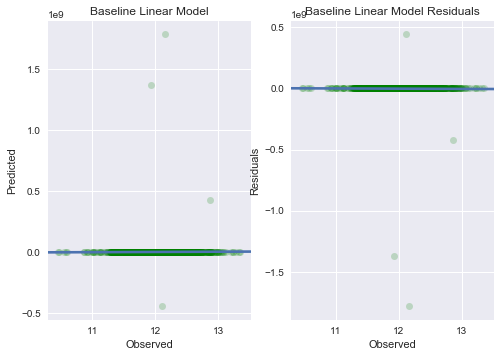

In [529]:
from sklearn.metrics import mean_squared_error

plt.subplot(1, 2, 1)
sns.regplot(y, preds1, scatter_kws=dict(color='green', alpha=0.2))
plt.title("Baseline Linear Model")
plt.xlabel("Observed")
plt.ylabel("Predicted")
print("Baseline linear model RMSE = ", baseline_RMSE)

plt.subplot(1, 2, 2)
sns.regplot(y, y-preds1, scatter_kws=dict(color='green', alpha=0.2))
plt.title("Baseline Linear Model Residuals")
plt.xlabel("Observed")
plt.ylabel("Residuals")


# 3. Feature Selection

Before starting this section it should be noted that I will try to be extra careful not to create contamination during feature selection. Meaning that I will select features constrained per fold in my cross-validation to ensure no data leakage happens.

## Filter methods

### Coefficient importance


In [2947]:
coeffs = pd.DataFrame(list(zip(X.columns, benchmark_model.steps[1][1].coef_)), columns=['Predictors', 'Coefficients'])

coeffs.sort_values(by='Coefficients', ascending=False)

,Predictors,Coefficients
11,1stFlrSF,1.680465e+08
12,2ndFlrSF,1.680465e+08
7,BsmtFinSF1,1.680465e+08
8,BsmtFinSF2,1.680465e+08
17,FullBath,1.958283e+06
15,BsmtFullBath,1.958283e+06
37,Total_porch_sf,1.049932e+06
18,HalfBath,9.791417e+05
16,BsmtHalfBath,9.791417e+05
41,hasbsmt,4.003698e+05


## Embedded methods

### Ridge Regression (L2 penalty)


In [65]:
from sklearn.linear_model import RidgeCV

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X, y)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

In [66]:
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

,RMSE
0.0001,0.113943
0.0003,0.112867
0.0005,0.112278
0.0007,0.111890
0.0009,0.111619
0.0100,0.110398
0.0500,0.109388
0.1000,0.108505
0.3000,0.106651
1.0000,0.104760


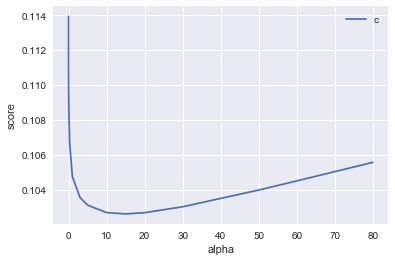

In [67]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [68]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(X, y)

cv_rmse(ridge_model2).mean()

0.10263463637867346

In [69]:
ridge_model2.steps[1][1].alpha_

14.6

### Lasso Regression (L1 penalty)

In [70]:
from sklearn.linear_model import LassoCV


alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X, y)

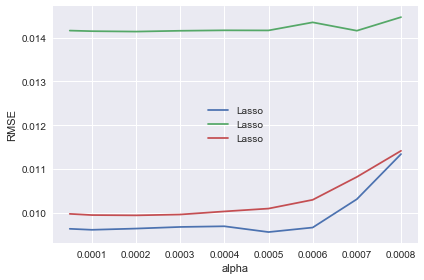

In [71]:
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [72]:
lasso_model2.steps[1][1].alpha_

0.00069999999999999999

In [73]:
cv_rmse(lasso_model2).mean()

0.10299719809830574

In [74]:
coeffs = pd.DataFrame(list(zip(X.columns, lasso_model2.steps[1][1].coef_)), columns=['Predictors', 'Coefficients'])

In [75]:
used_coeffs = coeffs[coeffs['Coefficients'] != 0].sort_values(by='Coefficients', ascending=False)
print(used_coeffs.shape)
print(used_coeffs)

(92, 2)
                Predictors  Coefficients
2              OverallQual      0.112749
35       Total_sqr_footage      0.100129
4                YearBuilt      0.096562
87    Neighborhood_Crawfor      0.086172
14               GrLivArea      0.080195
11                1stFlrSF      0.077902
152    Exterior1st_BrkFace      0.070110
10             TotalBsmtSF      0.066959
256         Functional_Typ      0.061497
103   Neighborhood_StoneBr      0.061188
102   Neighborhood_Somerst      0.057608
246         KitchenQual_Ex      0.052983
199            BsmtQual_Ex      0.049353
309           SaleType_New      0.046735
3              OverallCond      0.044895
210        BsmtExposure_Gd      0.038525
108        Condition1_Norm      0.038279
84    Neighborhood_BrkSide      0.035301
60             MSZoning_RL      0.034477
1                  LotArea      0.032123
195       Foundation_PConc      0.025664
5             YearRemodAdd      0.025349
97    Neighborhood_NridgHt      0.024946
24      

In [76]:
used_coeffs_values = X[used_coeffs['Predictors']]
used_coeffs_values.shape

(1453, 92)

In [77]:
overfit_test2 = []
for i in used_coeffs_values.columns:
    counts2 = used_coeffs_values[i].value_counts()
    zeros2 = counts2.iloc[0]
    if zeros2 / len(used_coeffs_values) * 100 > 99.5:
        overfit_test2.append(i)
        
overfit_test2

['PoolArea']

### Elastic Net (L1 and L2 penalty)
One of the issues with Lasso is that it's likely to pick, from correlated features, one at random. Elastic net would pick both. Its a bit of a mix between ridge and lasso. I decided to include it since R's implementation of ridge regression actually invovles some elasticNet properties. 

In [78]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X, y)

In [79]:
cv_rmse(elastic_model3).mean()

0.1026801104818051

In [80]:
print(elastic_model3.steps[1][1].l1_ratio_)
print(elastic_model3.steps[1][1].alpha_)

0.9
0.0002


### Xgboost
The project I made this notebook for we weren't allowed to use more advanced algorithms than lasso, ridge, elasticnet. This was added later to see if I could improve my score.


In [60]:
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor

Belows function was used to obtain the optimal boosting rounds. This is accomplished useing xgb.cv's early stopping. 

In [61]:
from sklearn.metrics import mean_squared_error

def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #Predict training set:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))



Gridsearching gave me optimal parameters for XGBoost

In [94]:
xgb3 = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X, y)

### Support Vector Regression

Gridsearching gave me optimal C and gamma for SVR.

In [63]:
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X, y)

### LightGBM

In [96]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [89]:
cv_rmse(lgbm_model).mean()

0.10779641071446713

In [92]:
lgbm_fit = lgbm_model.fit(X, y)

## Ensemble methods
Let's see if I can get a better performance on the test data by employing ensemble methods. To stay in the constraints of the exercise I won't employ stronger models but instead combine three models.

- LassoCV
- RidgeCV
- Elasticnet

Experimenting with averaging cost a lot of time since local RMSE and kaggle RMSLE are disconnected at this point. Basically I am optimizing the tradeoff between under and over fitting.

First I'll build a meta-regressor through a process called stacking generalizations which trains a model on a part of the training set (it gets split first into a new training set and a holdout set). Then the algorithm test these models on the holdout set and uses these predictions (called out-of-fold predictions) as input for the 'meta model'. Below is a grahpical representation of the process.

In [2974]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://i.imgur.com/QBuDOjs.jpg")

### Ensemble 1 - Stacking Generalization
To try to eek out more performance of our already decent rank let's try Stacking Generalization, I tried a few different options. Vecstack package from python seemed to be implementing it incorrectly, so instead I decided to use the mlxtend package.

In [98]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))


#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

#prepare dataframes
stackX = np.array(X)
stacky = np.array(y)

In [99]:
#scoring 

print("cross validated scores")

for model, label in zip([ridge, lasso, elasticnet, xgboost, lightgbm, stack_gen],
                     ['RidgeCV', 'LassoCV', 'ElasticNetCV', 'xgboost', 'lightgbm',
                      'StackingCVRegressor']):
    
    SG_scores = cross_val_score(model, stackX, stacky, cv=kfolds,
                               scoring='neg_mean_squared_error')
    print("RMSE", np.sqrt(-SG_scores.mean()), "SD", scores.std(), label)

cross validated scores
RMSE 0.103371764428 SD 0.00199368950964 RidgeCV
RMSE 0.103306098931 SD 0.00199368950964 LassoCV
RMSE 0.103399603846 SD 0.00199368950964 ElasticNetCV
RMSE 0.10767862674 SD 0.00199368950964 xgboost
RMSE 0.109132776671 SD 0.00199368950964 lightgbm
RMSE 0.106436372921 SD 0.00199368950964 StackingCVRegressor


In [100]:
stack_gen_model = stack_gen.fit(stackX, stacky)

### Ensemble 2 - averaging
Final averaging weights are mostly trial and error as at this point my local scores were so completely detached from my real kaggle score. In the end I felt that SVR wasn't helping my score so it's not included in my final predictions.

In [101]:
em_preds = elastic_model3.predict(testing_features)
lasso_preds = lasso_model2.predict(testing_features)
ridge_preds = ridge_model2.predict(testing_features)
stack_gen_preds = stack_gen_model.predict(testing_features)
xgb_preds = xgb_fit.predict(testing_features)
svr_preds = svr_fit.predict(testing_features)
lgbm_preds = lgbm_fit.predict(testing_features)

In [173]:
stack_preds = ((0.2*em_preds) + (0.1*lasso_preds) + (0.1*ridge_preds) + 
               (0.2*xgb_preds) + (0.1*lgbm_preds) + (0.3*stack_gen_preds))

## Actual predictions for Kaggle
I transform the predictions back to normal values because the model is trained with logSalePrice.

In [134]:
submission = pd.read_csv("sample_submission.csv")

In [170]:
submission.iloc[:,1] = np.expm1(stack_preds5)

In [175]:
submission.to_csv("final_submission.csv", index=False)